<a href="https://colab.research.google.com/github/matteogorni2/Deep_belief_network_KMNIST_project/blob/main/Cognition_computation_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Matteo Gorni - Cognition and Computation project

## Kuzushiji-MNIST (KMNIST) Project - Introduction


The **Kuzushiji-MNIST (KMNIST)** dataset is utilized for this project. KMNIST is a dataset designed as a drop-in replacement for the popular MNIST dataset. It features grayscale images of handwritten **Kuzushiji characters**, a cursive form of Japanese kanji, rather than Arabic numerals. This dataset provides a more challenging benchmark for machine learning models due to its richer and more complex patterns compared to MNIST.  

---

## Key Characteristics  

1. **Dataset Size**:  
   - **Training set**: 60,000 images  
   - **Test set**: 10,000 images  

2. **Image Properties**:  
   - Each image is a grayscale image of size **28x28 pixels**.  
   - Pixel values range from 0 (black) to 255 (white), similar to MNIST.  

3. **Number of Classes**:  
   - Contains **10 classes**, each representing a different Kuzushiji character from ancient Japanese literature.  

The 10 classes correspond to the following Kuzushiji characters:  

| Class Index | Character | Hiragana Equivalent | English Meaning |  
|-------------|-----------|---------------------|-----------------|  
| 0           | お         | o                   | "o" (sound)     |  
| 1           | き         | ki                  | "ki" (sound)    |  
| 2           | す         | su                  | "su" (sound)    |  
| 3           | つ         | tsu                 | "tsu" (sound)   |  
| 4           | な         | na                  | "na" (sound)    |  
| 5           | は         | ha                  | "ha" (sound)    |  
| 6           | ま         | ma                  | "ma" (sound)    |  
| 7           | や         | ya                  | "ya" (sound)    |  
| 8           | れ         | re                  | "re" (sound)    |  
| 9           | を         | wo                  | "wo" (sound)    |  

---

## Analysis and Evaluation  

The initial phase of this project focuses on fine-tuning the parameters of a Deep Belief Network (DBN) to enhance classification accuracy. A linear readout layer is implemented to classify the 10 classes based on features extracted by the DBN.  

To gain deeper insights into the learning process of the DBN, the following analyses are conducted:  

- **Visualizing receptive fields**: Images are generated to represent the learned weights at each layer of the RBM.  
- **Clustering internal representations**: Dendrograms are used to explore how the RBM organizes data during classification.  

A comparative evaluation is also performed between the DBN and a Feedforward Neural Network (FFNN) with a similar architecture and hyperparameters. This comparison highlights differences in classification accuracy and robustness to noise.  

The evaluation process includes:  
- **Confusion matrices**: To assess the classification performance of the models.  
- **Psychometric curves**: To examine accuracy trends under varying levels of noise and adversarial conditions.  

Finally, both models are subjected to adversarial attacks using the **Fast Gradient Sign Method (FGSM)** to test their resilience against adversarial examples, providing a comprehensive understanding of their robustness.  


# Importing libraries and downloading KMNIST

In this part of the notebook we import some useful libraries and get the dbn files, after that we download our data, normalize it, perform a train/test/val/split and move it to a torch device

In [ ]:
def get_dbn_library():
  files = ["DBN.py", "RBM.py"]
  repository_url = "https://raw.githubusercontent.com/flavio2018/Deep-Belief-Network-pytorch/master/"
  for file in files:
    ! wget -O {file} {repository_url}{file}

In [ ]:
%%capture
get_dbn_library()

In [ ]:
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import scipy.cluster as cluster
import sklearn.preprocessing
import torchvision as tv
import torch
import random
from torchvision import transforms
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns


from DBN import DBN


In [ ]:
print(torch.cuda.is_available())
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

True
cuda


In [ ]:
%%capture
# Download KMNIST train and test datasets
train_dataset = tv.datasets.KMNIST(root='./data', train=True, download=True)
test_dataset = tv.datasets.KMNIST(root='./data', train=False, download=True)

# Merge train and test datasets
data = torch.cat((train_dataset.data, test_dataset.data), dim=0)
targets = torch.cat((train_dataset.targets, test_dataset.targets), dim=0)

# Normalize pixel values to [0, 1]
data = data.float() / 255.0

# Split the data into train, validation, and test sets (80% train, 10% validation, 10% test)
train_data, temp_data, train_targets, temp_targets = train_test_split(
    data, targets, test_size=0.2, random_state=42
)
val_data, test_data, val_targets, test_targets = train_test_split(
    temp_data, temp_targets, test_size=0.5, random_state=42
)

# Move datasets to device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_data = train_data.to(device)
train_targets = train_targets.to(device)
val_data = val_data.to(device)
val_targets = val_targets.to(device)
test_data = test_data.to(device)
test_targets = test_targets.to(device)

print(f"Train size: {len(train_data)}, Validation size: {len(val_data)}, Test size: {len(test_data)}")


Train/test/val split leaves us with a 56000/7000/7000 in each set

In [ ]:
print(train_data.shape)
print(test_data.shape)
print(val_data.shape)

torch.Size([56000, 28, 28])
torch.Size([7000, 28, 28])
torch.Size([7000, 28, 28])


# Training and improving our Deep Belief Network model

In this part of the notebook I am going to first train a Deep Belief Network using the "default" parameters we used in the labs, then I am going to perform a Linear Readout to assess model's performance. After that, I am going to try and perform a random search procedure over the search space in order to fine tune our model. Below there is a brief explanation of what each function does


1. `LinearModel`: this class defines a simple linear classifier. It consists of a linear layer which from the `layer_size` outputs 10 values, corresponding to the number of classes for KMNIST.

2. `get_kth_layer_repr`: extract the hidden representations from the k-th layer of a DBN

3. `train_linear(linear, hidden_reprs, epochs=1000)`: this function trains the linear classifier on the hidden representations extracted from the DBN. It uses stochastic gradient descent (SGD) with a learning rate of 0.05. The model is trained for the specified number of epochs (default is 1000).

4. `compute_accuracy(predictions_test, targets)`: this function computes the accuracy of the linear classifier on test data by comparing the predicted class indices with the true targets. It returns the accuracy as a floating-point value.


In [ ]:
class LinearModel(torch.nn.Module):
  def __init__(self, layer_size):
    super().__init__()
    self.linear = torch.nn.Linear(layer_size, 10) #linear layer

  def forward(self, x): #function to activate the layer
    return self.linear(x)


def get_kth_layer_repr(model,input, k, device):
  flattened_input = input.view((input.shape[0], -1)).type(torch.FloatTensor).to(device)
  # Use correct weight matrix for the k-th layer
  hidden_repr, __ = model.rbm_layers[k].to_hidden(flattened_input)
  return hidden_repr

def train_linear(linear, hidden_reprs):
  optimizer = torch.optim.SGD(linear.parameters(), lr=0.05)
  loss_fn = torch.nn.CrossEntropyLoss()
  epochs = 1000

  for epoch in range(epochs):
    optimizer.zero_grad()
    predictions = linear(hidden_reprs).squeeze()
    targets = train_targets.reshape(predictions.shape[0])  # here are the labels
    loss = loss_fn(predictions, targets)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
      print("epoch : {:3d}/{}, loss = {:.4f}".format(epoch + 1, epochs, loss))

def compute_accuracy(predictions_test, targets):
  predictions_indices = predictions_test.max(axis=1).indices  # convert probabilities to indices
  accuracy = (predictions_indices == targets).sum() / len(targets)
  return accuracy.item()


The function `get_dbn_performance_scores` I have written below performs a **linear readout** of our trained model and computes accuracy scores, while also storing each trained Linear Classifier, which will be needed below when dealing with noise injection. I have written the function so that it adjusts dinamically to layer size.

Linear read-outs serve as a method to assess the quality of representations learned by each layer of a Deep Belief Network (DBN). This technique involves training a basic linear classifier to associate these features with the target output labels.

Because the classifier lacks the ability to learn intricate patterns, its performance provides a direct measure of the quality and separability of the features extracted at a specific layer.



In [ ]:
def get_dbn_performance_scores(dbn, train_data, test_data, test_targets):
    # Ensure train and test data are flattened
    train_data = train_data.view(train_data.shape[0], -1).type(torch.FloatTensor).to(device)
    test_data = test_data.view(test_data.shape[0], -1).type(torch.FloatTensor).to(device)

    # Get hidden representations
    hidden_reprs = []
    current_repr = train_data
    for k in range(len(dbn.rbm_layers)):
        current_repr = get_kth_layer_repr(dbn,current_repr, k, device)
        hidden_reprs.append(current_repr)

    # Train linear classifiers for each hidden layer
    classifiers = []
    for k, hidden_repr in enumerate(hidden_reprs):
        layer_size = dbn.rbm_layers[k].W.shape[1]
        linear = LinearModel(layer_size).to(device)
        train_linear(linear, hidden_repr)
        classifiers.append(linear)

    # Evaluate performance on test data
    test_hidden_reprs = []
    current_repr = test_data
    for k in range(len(dbn.rbm_layers)):
        current_repr = get_kth_layer_repr(dbn,current_repr, k, device)
        test_hidden_reprs.append(current_repr)

    accuracies = []
    for k, (linear, hidden_repr) in enumerate(zip(classifiers, test_hidden_reprs)):
        predictions = linear(hidden_repr)
        accuracy = compute_accuracy(predictions, test_targets)
        accuracies.append(accuracy)

    return accuracies,classifiers

A **Deep Belief Network (DBN)** is a deep neural network composed of multiple Restricted Boltzmann Machines (RBM) stacked hierarchically, where the output of each RBM becomes the input for the next one. This hierarchical structure allows the network to learn increasingly abstract representations of the data, with each successive layer capturing more complex and high-level features.First,let's define a DBN architecture using "default" values.



In [ ]:
dbn_KMNIST = DBN(visible_units=28*28,
                hidden_units=[500, 600, 900],
                k=1,
                learning_rate=0.1,
                learning_rate_decay=False,
                initial_momentum=0.5,
                final_momentum=0.95,
                weight_decay=0.0001,
                xavier_init=False,
                increase_to_cd_k=False,
                use_gpu=torch.cuda.is_available())

In [ ]:
num_epochs = 20
batch_size = 250

dbn_KMNIST.train_static(
    train_data,
    train_targets,
    num_epochs,
    batch_size
)

--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |4.9895     |0.1148       |547.8338   |9.1119     |
|20    |4.6311     |0.0952       |508.0401   |6.4512     |
--------------------
Training RBM layer 2
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |5.7434     |0.1008       |358.4653   |4.3406     |
|20    |5.1603     |0.0704       |341.0312   |4.4611     |
--------------------
Training RBM layer 3
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |3.7529     |0.0827       |392.1951   |6.3998     |
|20    |3.3294     |0.0641       |362.7344   |4.3169     |


In [ ]:
%%capture
test_results,_=get_dbn_performance_scores(dbn_KMNIST, train_data, test_data, test_targets)



In [ ]:
print(results)


[0.8151428699493408, 0.8157142996788025, 0.821571409702301]



Our model performance is lower than when we used the MNIST datasets. this is to be expected, since KMNIST input data has inherently more complex shapes and it's therefore harder to learn




# Fine Tuning
In this part of the notebook I am going to try to improve the performance of my model, in order to do so I am going to employ a random search principle in order to find an architecture that is better suited to handle my data first, once i find said architecture, i am going to try and perform some hyperparameter optimization.

##Changing model architecture

In this section, I will investigate whether altering the architecture of the Deep Belief Network (DBN) improves its performance on the KMNIST dataset. Although our lab experiments showed that increasing the layer depth did not significantly enhance performance, it is still worth testing this approach with KMNIST, as it contains more complex shapes that may benefit from deeper models.

The function `explore_random_architectures_and_depth` generates a set of random models with varying layer sizes and evaluates their performance using a linear readout. Since I have no prior knowledge of which architecture might perform best, I decided to explore these models randomly. The only constraint I imposed is that each model must have hidden units in increasing size. This design choice is grounded in the theory that, as the network learns a hierarchical representation of the data, progressively larger layers may capture increasingly complex features.

In [ ]:
def explore_random_architectures_and_depth(
    min_depth,          # Minimum depth of the model
    max_depth,          # Maximum depth to explore
    hidden_unit_range,  # Tuple with range of hidden units (min, max)
    num_models_per_depth, # Number of models to test per depth
    train_data,
    train_targets,
    val_data,
    val_targets
):
    depth_results = {}  # Dictionary to store results per depth

    def generate_and_evaluate(depth):
        """Generates and evaluates random architectures for a given depth."""
        # Generate a list of lists with random integers in increasing order
        hidden_units_list = [
            sorted(random.randint(hidden_unit_range[0], hidden_unit_range[1]) for _ in range(depth))
            for _ in range(num_models_per_depth)
        ]

        print(f"Generated hidden units for depth {depth}: {hidden_units_list}")

        results = []  # To store accuracy per layer for models of this depth
        for hidden_units in hidden_units_list:
            # Define the DBN model with the sampled hidden units
            random_dbn_KMNIST = DBN(
                visible_units=28 * 28,
                hidden_units=hidden_units,
                k=1,
                learning_rate=0.1,
                learning_rate_decay=False,
                initial_momentum=0.5,
                final_momentum=0.95,
                weight_decay=0.0001,
                xavier_init=False,
                increase_to_cd_k=False,
                use_gpu=torch.cuda.is_available()
            )

            # Train the model and evaluate on validation data
            random_dbn_KMNIST.train_static(train_data, train_targets, num_epochs=10, batch_size=250)  # Adjust as needed
            model_accuracies, _ = get_dbn_performance_scores(random_dbn_KMNIST, train_data, val_data, val_targets)

            # Store metrics for each layer
            results.append((hidden_units, model_accuracies))

        # Return results for all models at this depth
        return results

    # Process each depth
    for depth in range(min_depth, max_depth + 1):
        models_results = generate_and_evaluate(depth)

        # Rank models based on the LAST layer accuracy
        sorted_results = sorted(
            models_results,
            key=lambda x: x[1][-1],  # Use the last layer accuracy
            reverse=True
        )

        # Store the best-performing model for this depth
        depth_results[depth] = sorted_results[0]  # Best model for this depth

    # Compare best models across depths based on LAST layer accuracy
    best_models = {
        depth: (hidden_units, accuracies[-1])  # Store best hidden units and last layer accuracy
        for depth, (hidden_units, accuracies) in depth_results.items()
    }

    # Rank depths based on the last layer accuracy of the best models
    ranked_depths = sorted(
        best_models.items(),
        key=lambda x: x[1][1],  # Compare by last layer accuracy
        reverse=True
    )

    return ranked_depths, depth_results

def print_results(ranked_depths, depth_results):
    """Prints a detailed summary of the results."""
    print("\n===== Summary of Results =====")
    print("Ranked Best Models Across Depths:")
    for rank, (depth, (hidden_units, last_accuracy)) in enumerate(ranked_depths, 1):
        print(f"Rank {rank}: Depth {depth}, Hidden Units {hidden_units}, Last Layer Accuracy: {last_accuracy:.4f}")

    print("\nDetailed Results Per Depth:")
    for depth, (hidden_units, accuracies) in depth_results.items():
        print(f"\nDepth {depth}: Best Model")
        print(f"  Hidden Units: {hidden_units}")
        print(f"  Accuracies per Layer: {accuracies}")
        print(f"  Last Layer Accuracy: {accuracies[-1]:.4f}")


In [ ]:
%%capture
ranked_depth, depth_results = explore_random_architectures_and_depth(
    min_depth=3,
    max_depth=10,
    hidden_unit_range=(400, 1100),
    num_models_per_depth=1,
    train_data=train_data,
    train_targets=train_targets,
    val_data=val_data,
    val_targets=val_targets
)



In [ ]:
print_results(ranked_depth, depth_results)


===== Summary of Results =====
Ranked Best Models Across Depths:
Rank 1: Depth 9, Hidden Units [428, 465, 620, 643, 881, 911, 952, 973, 1080], Last Layer Accuracy: 0.8727
Rank 2: Depth 7, Hidden Units [415, 425, 648, 670, 803, 996, 1020], Last Layer Accuracy: 0.8667
Rank 3: Depth 5, Hidden Units [546, 651, 778, 1014, 1045], Last Layer Accuracy: 0.8660
Rank 4: Depth 10, Hidden Units [425, 491, 547, 550, 673, 750, 823, 893, 1020, 1054], Last Layer Accuracy: 0.8604
Rank 5: Depth 3, Hidden Units [458, 575, 751], Last Layer Accuracy: 0.8550
Rank 6: Depth 8, Hidden Units [612, 613, 687, 704, 852, 857, 880, 1064], Last Layer Accuracy: 0.8533
Rank 7: Depth 6, Hidden Units [664, 799, 883, 917, 957, 1068], Last Layer Accuracy: 0.8503
Rank 8: Depth 4, Hidden Units [492, 614, 770, 1025], Last Layer Accuracy: 0.8414

Detailed Results Per Depth:

Depth 3: Best Model
  Hidden Units: [458, 575, 751]
  Accuracies per Layer: [0.828000009059906, 0.8251428604125977, 0.8550000190734863]
  Last Layer Accur


We observe that increasing layer depth does not significantly improve performance, and in some cases, deeper networks even show slight decreases in accuracy (e.g., Depth 10 at 86.04% vs. Depth 9 at 87.27%).  

The three-layer model still performs very well, reaching 85.5% accuracy, making it a competitive choice. Given its efficiency and faster training time I will keep using three layers for the rest of this project.


## Hyperparameter Optimization

In this section of the notebook, I will explore better hyperparameters for our DBN model. The `random_search` function randomly samples from the hyperparameter space to identify configurations that improve performance.  

For this project, I am specifically focusing on optimizing:  

- **Learning rate**  
- **Number of hidden units per layer**  
- **Number of contrastive divergence steps (k)**  
- **Batch size**  



In [ ]:
def random_search(num_random_search_trials=40, num_epochs=10, train_data=None, train_targets=None, val_data=None, val_targets=None):
    # Define the smaller search space with only relevant hyperparameters
    search_space = {
        "learning_rate": lambda: np.random.uniform(0.01, 0.15),
        "k": lambda: np.random.choice([1, 2, 3, 4, 5]),
        "hidden_units": lambda: sorted(np.random.choice(range(500, 1000), size=3, replace=False)),  # Three random hidden units in increasing order
        "batch_size": lambda: np.random.choice([50,100,150, 250])
        }

    # Step 3: Perform Random Search
    best_hyperparams = None
    best_val_accuracy = 0

    for trial in range(num_random_search_trials):
        # Sample hyperparameters
        hyperparams = {key: sampler() for key, sampler in search_space.items()}
        learning_rate = hyperparams["learning_rate"]
        k = hyperparams["k"]
        hidden_units = hyperparams["hidden_units"]
        batch_size = hyperparams["batch_size"]
        # All other hyperparameters are fixed to False
        batch_size = int(batch_size) # Convert batch_size to a Python integer

        # Initialize DBN with sampled hyperparameters
        dbn_KMNIST = DBN(
            visible_units=28 * 28,
            hidden_units=hidden_units,  # Random hidden units selected, sorted in increasing order
            k=k,
            learning_rate=learning_rate,
            learning_rate_decay=False,
            initial_momentum=0.5,
            final_momentum=0.95,
            weight_decay=False,
            xavier_init=False,
            increase_to_cd_k=False,
            use_gpu=torch.cuda.is_available(),
        )

        dbn_KMNIST.train_static(train_data, train_targets, num_epochs, batch_size)
        val_accuracy = get_dbn_performance_scores(dbn_KMNIST, train_data, val_data, val_targets)[0][-1]  # Last layer predictions to assess performance

        # Log Results
        print(f"Trial {trial + 1}: {hyperparams}, Validation Accuracy: {val_accuracy:.4f}")
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_hyperparams = hyperparams

    return best_hyperparams, best_val_accuracy


In [ ]:
best_hyperparams, best_val_accuracy = random_search(num_random_search_trials=50, num_epochs=10, train_data=train_data, train_targets=train_targets, val_data=val_data, val_targets=val_targets)


--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |11.0992     |0.2397       |204.0141   |4.6440     |
--------------------
Training RBM layer 2
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |14.3546     |0.2841       |181.7058   |4.3816     |
--------------------
Training RBM layer 3
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |9.4023     |0.1994       |211.8318   |5.4787     |
epoch :   1/1000, loss = 2.3636
epoch : 101/1000, loss = 0.9899
epoch : 201/1000, loss = 0.8109
epoch : 301/1000, loss = 0.7320
epoch : 401/1000, loss = 0.6852
epoch : 501/1000, loss = 0.6534
epoch : 601/1000, loss = 0.6298
epoch : 701/1000, loss = 0.6115
epoch : 801/1000, loss = 0.5965
epoch : 901/1000, loss = 0.5841
epoch :   1/1000, loss = 2.3485
epoch : 101/1000, loss = 1.0000
epoch : 201/1000, loss = 0.8232
epoch : 301/1000, loss = 0.7441
epoch : 401/1000, loss = 0.6969
epoch : 501/1000, loss = 0.6646
epoch : 6

In [ ]:
print("\nBest Hyperparameters:", best_hyperparams)
print("Best Validation Accuracy:", best_val_accuracy)



Best Hyperparameters: {'learning_rate': 0.04491584886605346, 'k': 4, 'hidden_units': [545, 804, 921], 'batch_size': 50}
Best Validation Accuracy: 0.8825713992118835


In [ ]:
#run this when you dont want to rerun random search
best_hyperparams = {'learning_rate': 0.04491584886605346, 'k': 4, 'hidden_units': [545, 804, 921], 'batch_size': 50}

##Final model evaluation
Now that we found a better performing architecture and better performing hyperparameters, it is now time to build the model we are going to be using for the rest of the notebook!

In [ ]:
# Final Model Evaluation (on Test Set)
num_epochs = 50



dbn_KMNIST = DBN(
            visible_units=28 * 28,
            hidden_units=best_hyperparams["hidden_units"],
            k=best_hyperparams["k"],
            learning_rate=best_hyperparams["learning_rate"],
            learning_rate_decay=False,
            initial_momentum=0.5,
            final_momentum=0.95,
            weight_decay=False,
            xavier_init=False,
            increase_to_cd_k=False,
            use_gpu=torch.cuda.is_available(),
            )

dbn_KMNIST.train_static(train_data, train_targets, num_epochs, best_hyperparams['batch_size'])



--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |2.3775     |0.1050       |564.5259   |7.6874     |
|20    |2.2534     |0.1019       |558.0087   |7.9236     |
|30    |2.2324     |0.1060       |559.9498   |8.2711     |
|40    |2.2214     |0.1015       |562.3120   |7.8262     |
|50    |2.2245     |0.1001       |567.5189   |8.9290     |
--------------------
Training RBM layer 2
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.6452     |0.0609       |358.0881   |4.0015     |
|20    |1.5491     |0.0556       |344.1457   |4.2170     |
|30    |1.5278     |0.0565       |341.6686   |4.2259     |
|40    |1.5170     |0.0578       |341.2235   |4.1817     |
|50    |1.5085     |0.0574       |340.7633   |4.1981     |
--------------------
Training RBM layer 3
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.0049     |0.0447       |417.0388   |5.0546     |
|20    |0.8759     |0.0377       |373.8871   |4.646

In [ ]:
final_accuracies,linear_classifiers=get_dbn_performance_scores(dbn_KMNIST, train_data, test_data, test_targets)

epoch :   1/1000, loss = 2.3350
epoch : 101/1000, loss = 1.2119
epoch : 201/1000, loss = 0.9278
epoch : 301/1000, loss = 0.7981
epoch : 401/1000, loss = 0.7202
epoch : 501/1000, loss = 0.6668
epoch : 601/1000, loss = 0.6271
epoch : 701/1000, loss = 0.5961
epoch : 801/1000, loss = 0.5709
epoch : 901/1000, loss = 0.5500
epoch :   1/1000, loss = 2.3294
epoch : 101/1000, loss = 1.1912
epoch : 201/1000, loss = 0.9037
epoch : 301/1000, loss = 0.7688
epoch : 401/1000, loss = 0.6872
epoch : 501/1000, loss = 0.6312
epoch : 601/1000, loss = 0.5897
epoch : 701/1000, loss = 0.5573
epoch : 801/1000, loss = 0.5312
epoch : 901/1000, loss = 0.5094
epoch :   1/1000, loss = 2.2964
epoch : 101/1000, loss = 1.1763
epoch : 201/1000, loss = 0.8846
epoch : 301/1000, loss = 0.7507
epoch : 401/1000, loss = 0.6701
epoch : 501/1000, loss = 0.6148
epoch : 601/1000, loss = 0.5738
epoch : 701/1000, loss = 0.5419
epoch : 801/1000, loss = 0.5160
epoch : 901/1000, loss = 0.4945


In [ ]:
print(final_accuracies)

[0.8571428656578064, 0.8704285621643066, 0.8775714039802551]


Our performance improved by rougly 3%!

# Visualizing receptive fields
To gain insight into how the model processes data at different layers, I visualize the receptive fields of each hidden layer.

I anticipate that the first layer will detect more general features, whereas deeper layers will extract increasingly complex patterns by integrating information from the preceding layers.

Below i provide a brief explanation of some usefuls functions we were presented during the labs

1 `get_weights(dbn, layer)`: Retrieve the weight parameters from a specific layer of the DBN.

2 `apply_threshold(weights, threshold=0)`: Set weight values below a given threshold to zero or another specified value.

3 `apply_min_max_scaler(learned_weights)`: Normalize the weight values using min-max scaling.

4 `plot_layer_receptive_fields(weights)`: Visualize the receptive fields of a particular DBN layer.

In [ ]:
# retrieve the weight matrix for a specific layer from the DBN
def get_weights(dbn, layer):
  return dbn.rbm_layers[layer].W.cpu().numpy()

# apply a threshold to the weights, zeroing out values below the threshold
def apply_threshold(weights, threshold=0):
  return weights * (abs(weights) > threshold)

# scale the weights to a range between 0 and 1 using Min-Max normalization
def apply_min_max_scaler(learned_weights):
  original_shape = learned_weights.shape
  min_max_scaler = sklearn.preprocessing.MinMaxScaler()
  min_max_scaled_learned_weights = min_max_scaler.fit_transform(learned_weights.ravel().reshape(-1,1))
  min_max_scaled_learned_weights = min_max_scaled_learned_weights.reshape(original_shape)
  return min_max_scaled_learned_weights


# plot the receptive fields for a layer of weights as 28x28 grayscale images
def plot_layer_receptive_fields(weights):
  num_subplots = 100
  n_rows_cols = int(math.sqrt(num_subplots))
  fig, axes = plt.subplots(n_rows_cols, n_rows_cols, sharex=True, sharey=True, figsize=(10, 10))
  for i in range(num_subplots):
    row = i % n_rows_cols
    col = i // n_rows_cols
    axes[row, col].imshow(weights[i,:].reshape((28,28)), cmap=plt.cm.gray)


Function `compute_and_plot_receptive_fields(dbn_model, max_layer, threshold=0.1, plot_shape=(28, 28))` computes and plots each layer's receptive fields dinamically

In [ ]:
def compute_and_plot_receptive_fields(dbn_model, max_layer, threshold=0.1, plot_shape=(28, 28)):
    """
    Compute and plot the receptive fields for each layer of a DBN model.

    Parameters:
    - dbn_model: The trained DBN model object.
    - max_layer: The maximum layer to compute receptive fields for (starting from 0).
    - threshold: Threshold value for weight pruning. Default is 0.1.
    - plot_shape: Tuple indicating the shape to plot receptive fields. Default is (28, 28).
    """
    import numpy as np

    # Initialize the weight projection with the identity matrix
    w_product = np.eye(plot_shape[0] * plot_shape[1])  # Assuming the input is in pixel space

    for layer in range(max_layer + 1):
        # Get weights for the current layer
        weights = get_weights(dbn_model, layer=layer)

        # Apply thresholding
        weights = apply_threshold(weights, threshold)

        # Combine with previous layers' weights
        w_product = w_product @ weights

        # Threshold and scale the combined weights
        w_product = apply_threshold(w_product, threshold)
        w_product = apply_min_max_scaler(w_product)

        # Plot the receptive fields for the current layer
        print(f"Plotting receptive fields for layer {layer + 1}...")
        plot_layer_receptive_fields(w_product.T)



Plotting receptive fields for layer 1...
Plotting receptive fields for layer 2...
Plotting receptive fields for layer 3...


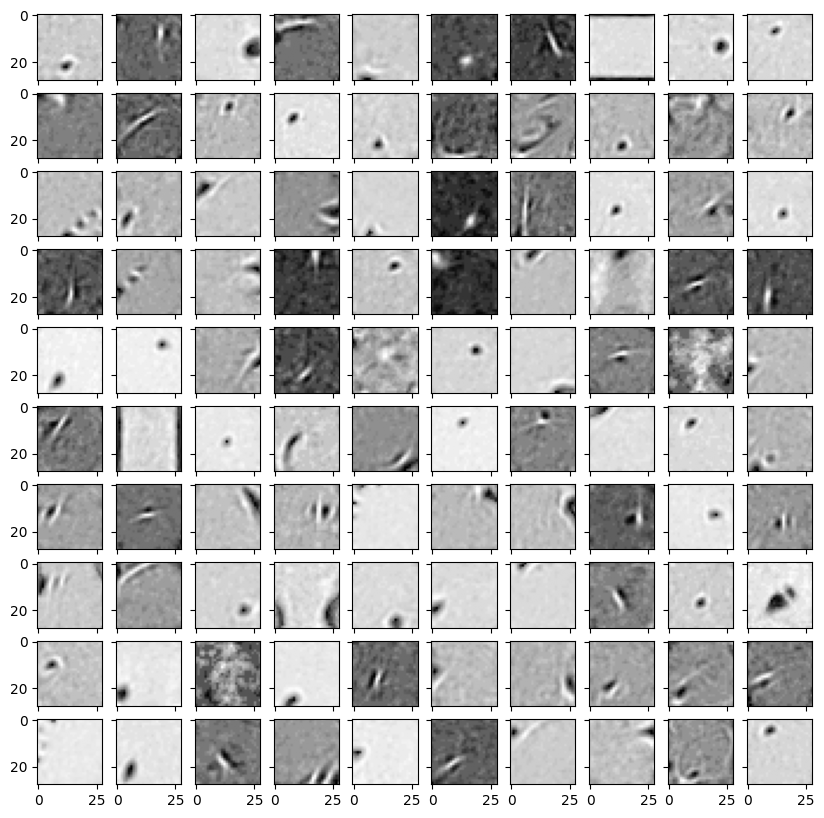

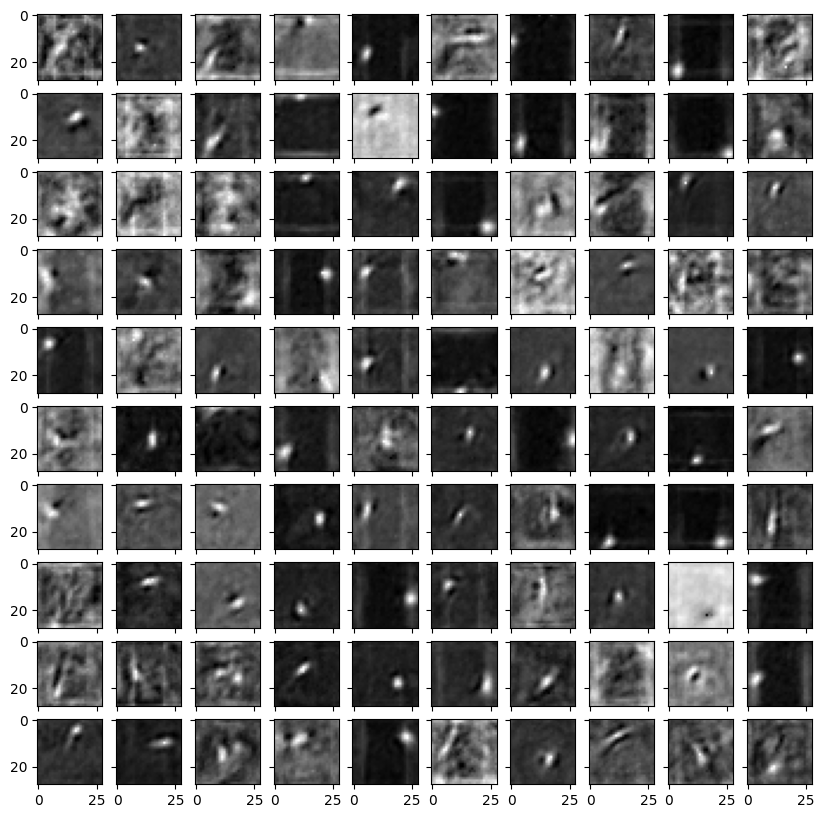

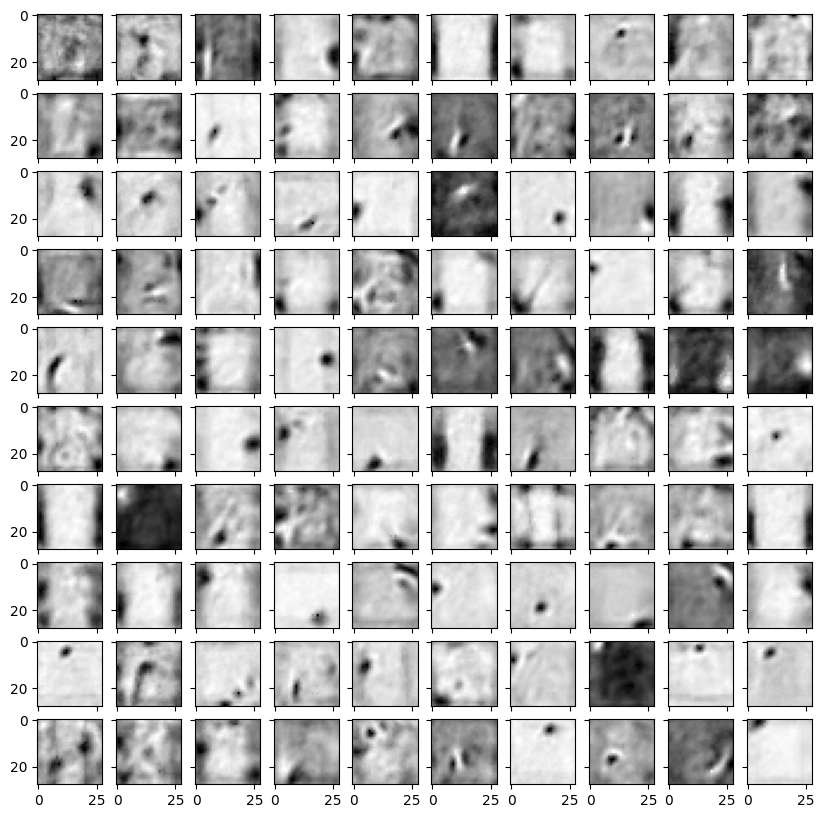

In [ ]:
compute_and_plot_receptive_fields(dbn_KMNIST, max_layer=2, threshold=0.1, plot_shape=(28, 28))

We can see that there is in fact a hierarchical representation of knowledge: first 2 layers are capturing mainly simpole features (edges, single points in the images,corners). While some of the third layer neurons are capturing much more complex shapes

# Clustering internal representations- Plotting dendrograms

I apply a hierarchical clustering algorithm to examine the similarities among the internal representations learned by the model. The implementation consists of the following steps:

Centroid computation: For each class, I determine the centroid of the learned representations. This provides an average representation for each class, capturing its key characteristics within the hidden activation space. ``
(`get_label_to_mean_hidd_repr`)
Construction of the centroid matrix: Once centroids are computed for all classes, I compile them into a matrix representing the mean hidden activations for each class. This matrix is organized separately for each hidden layer, enabling analysis of how representations evolve across different layers of the DBN. `(get_hidden_reprs_matrix)`

Dendrogram visualization: I generate a dendrogram for each hidden layer to illustrate the hierarchical clustering structure. (`plot_dendrogram`)








In [ ]:
def get_mask(label):  # we use this function to filter by class
  labels = train_targets.cpu().numpy()
  return labels == label

def get_label_to_mean_hidd_repr(hidden_repr):
  hidden_repr_np = hidden_repr.cpu().numpy()
  return {
    label: hidden_repr_np[get_mask(label)].mean(axis=0)  # here we filter by class and compute the mean
    for label in range(10)
  }

def get_hidden_reprs_matrix(hidden_repr):  # we use this to build the matrices
  label_to_mean_hidd_repr = get_label_to_mean_hidd_repr(hidden_repr)
  return np.concatenate(
    [np.expand_dims(label_to_mean_hidd_repr[label], axis=0)  # here we adjust the shape of centroids to do the concat
    for label in range(10)])

In [ ]:
#apply the function to all layers (1,2,3):level we want to investigate
hidden_repr_1 = get_kth_layer_repr(dbn_KMNIST,train_data,0, device) #dammi la rappresentazione del layer kappesimo
hidden_repr_2 = get_kth_layer_repr(dbn_KMNIST,hidden_repr_1, 1, device)
hidden_repr_3 = get_kth_layer_repr(dbn_KMNIST,hidden_repr_2, 2, device)
print(hidden_repr_1.shape)
print(hidden_repr_2.shape)
print(hidden_repr_3.shape)

#6000 = number of images in the traning set
#400, 500, 800 = size of hidden layers defined in the DBM
#torch.Size([6000, 400]) = internal representation of the DBM in the first layer

torch.Size([56000, 545])
torch.Size([56000, 804])
torch.Size([56000, 921])


In [ ]:
#using representation similarity matrix just derived
#focus on third hidden layer (can do with all layers)
#clustering is showing that the images of digit 3 in general gets cluster together and more similar to the images of digit 5  that 0 (4 and 9 more similar that 4 and 7 even though they are grouped together, even if more similar the three that 0)
#network judges similarities between digits
#creates all groups and clusters
def plot_dendrogram(mean_repr_matrix, title="",ax=None):
  if ax is None:
    fig, ax = plt.subplots()
  linkage = cluster.hierarchy.linkage(mean_repr_matrix, method="complete")  # we run the clustering algorithm here
  dendrogram = cluster.hierarchy.dendrogram(linkage,ax=ax)
  ax.set_title(title)

In [ ]:
mean_hidd_repr_matrix_1 = get_hidden_reprs_matrix(hidden_repr_1)
mean_hidd_repr_matrix_2 = get_hidden_reprs_matrix(hidden_repr_2)
mean_hidd_repr_matrix_3 = get_hidden_reprs_matrix(hidden_repr_3)

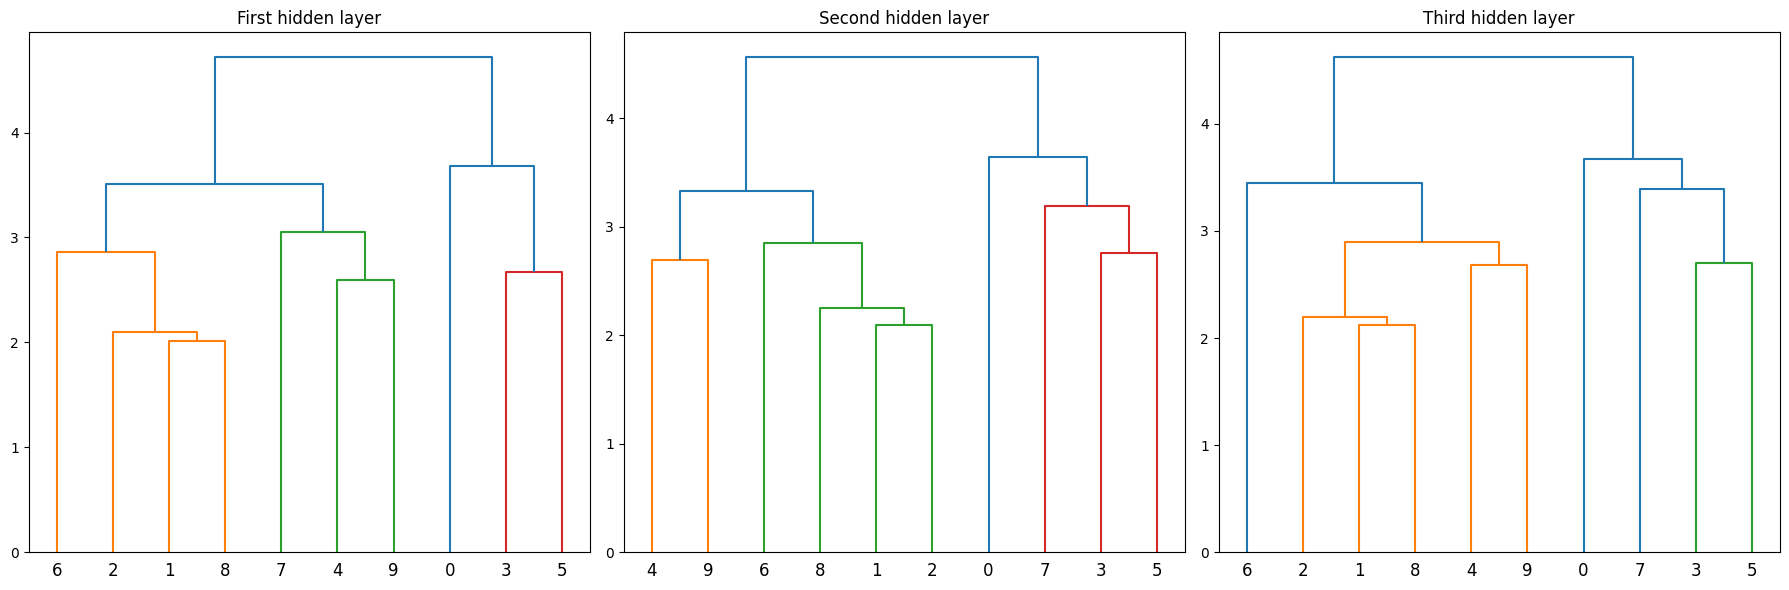

In [ ]:
# Create a figure with subplots arranged side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns
# Adjust the size to fit all three plots

# Plot each dendrogram on a different subplot
plot_dendrogram(mean_hidd_repr_matrix_1, "First hidden layer", axes[0])
plot_dendrogram(mean_hidd_repr_matrix_2, "Second hidden layer", axes[1])
plot_dendrogram(mean_hidd_repr_matrix_3, "Third hidden layer", axes[2])

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


| Class Index | Character | Hiragana Equivalent | English Meaning |  
|-------------|-----------|---------------------|-----------------|  
| 0           | お         | o                   | "o" (sound)     |  
| 1           | き         | ki                  | "ki" (sound)    |  
| 2           | す         | su                  | "su" (sound)    |  
| 3           | つ         | tsu                 | "tsu" (sound)   |  
| 4           | な         | na                  | "na" (sound)    |  
| 5           | は         | ha                  | "ha" (sound)    |  
| 6           | ま         | ma                  | "ma" (sound)    |  
| 7           | や         | ya                  | "ya" (sound)    |  
| 8           | れ         | re                  | "re" (sound)    |  
| 9           | を         | wo                  | "wo" (sound)    |  

---


The KMNIST characters (Hiragana) are harder to distinguish compared to regular MNIST digits. Still, we can observe the following from the confusion matrix:

つ/tsu (Class 3) and は/ha (Class 5) often overlap, which seems unusual from a human perspective.
However, つ/tsu (Class 3) is progressively classified closer to や/ya (Class 7) and お/o (Class 0), which makes sense as these characters share a similar curved shape in their representation.


# Comparison with a feed-forward neural network

An FFNN model is implemented with the same architecture as the DBN, consisting of three hidden layers with [500, 800, 1000] neurons. This design ensures that the comparison remains focused on the training method rather than variations in model capacity.

The primary distinction between the two models lies in their learning strategies. The FFNN is trained using supervised learning, where it directly maps input images to target labels. In contrast, the DBN relies on unsupervised learning to construct feature representations without considering the classification objective, which is only introduced later through a linear read-out layer.

In [ ]:
class Feedforward(torch.nn.Module):
  def __init__(self, first_hidden_layer_size, second_hidden_layer_size, third_hidden_layer_size):
    super().__init__()
    self.first_hidden = torch.nn.Linear(784, first_hidden_layer_size)
    self.second_hidden = torch.nn.Linear(first_hidden_layer_size, second_hidden_layer_size)
    self.third_hidden = torch.nn.Linear(second_hidden_layer_size, third_hidden_layer_size)
    self.output = torch.nn.Linear(third_hidden_layer_size, 10)

  def forward(self, input):
    relu = torch.nn.ReLU()
    first_hidden_repr = relu(self.first_hidden(input))
    second_hidden_repr = relu(self.second_hidden(first_hidden_repr))
    third_hidden_repr = relu(self.third_hidden(second_hidden_repr))
    output = self.output(third_hidden_repr)
    return output

In [ ]:
ffnn = Feedforward(545, 804, 921).to(device) #voglio che abbia stessi param del dbm

In [ ]:
train_linear(ffnn, train_data.reshape((56000, 784))) #1050 for how long to train the model, same as dbm

epoch :   1/1000, loss = 2.3030
epoch : 101/1000, loss = 2.1993
epoch : 201/1000, loss = 1.5075
epoch : 301/1000, loss = 0.9448
epoch : 401/1000, loss = 0.7650
epoch : 501/1000, loss = 0.6596
epoch : 601/1000, loss = 0.5894
epoch : 701/1000, loss = 0.5377
epoch : 801/1000, loss = 0.4951
epoch : 901/1000, loss = 0.4590


In [ ]:
predictions_ffnn = ffnn(test_data.reshape((7000, 784)))

In [ ]:
compute_accuracy(predictions_ffnn, test_targets)

0.8641428351402283

# Robustness to noise

We will now inject some noise in the input images and see how much the representations learned by the DBN and the feed-forward network are robust to perturbations in the sensory signal.

Similarly to what happens in psychophysical experiments, this will allow to create a psychometric curve describing the decrease in classification accuracy with respect to the noise level.

In [ ]:
def inject_noise(KMNIST_data, noise_level):

  ### TASK: create a very simple function that adds some Gaussian noise (see torch.randn function) to the MNIST data
  random_gaussian_tensor = torch.randn(KMNIST_data.shape, device=device)*noise_level
  return KMNIST_data + random_gaussian_tensor #mnist_data è gia stato scalato

Let's see what a noisy image looks like:

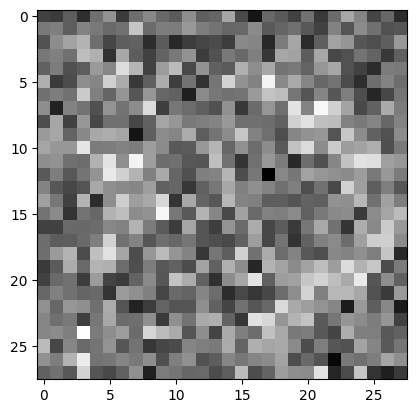

In [ ]:
noise_level = 0.7
KMNIST_test_with_noise = inject_noise(test_data, noise_level)
__ = plt.imshow(KMNIST_test_with_noise[0].reshape(28,28).to("cpu"), cmap="gray")

We will now compute the hidden representations for the noisy images using the DBN. Then, we will use the read-out classifiers that we trained on the representations without noise to classify the noisy stimuli.

In [ ]:
def get_accuracy_values_at_noise_level(noise_level):

  KMNIST_test_with_noise = inject_noise(test_data, noise_level)  # first, let's create noisy test images

  hidden_repr_1_noisy = get_kth_layer_repr(dbn_KMNIST,KMNIST_test_with_noise, 0, device)  # here we compute the DBN representations
  hidden_repr_2_noisy = get_kth_layer_repr(dbn_KMNIST,hidden_repr_1_noisy, 1, device)
  hidden_repr_3_noisy = get_kth_layer_repr(dbn_KMNIST,hidden_repr_2_noisy, 2, device)

  predictions_first_hidden_noisy = linear_classifiers[0](hidden_repr_1_noisy)  # here we use the previously-trained read-out classifiers
  predictions_second_hidden_noisy = linear_classifiers[1](hidden_repr_2_noisy)
  predictions_third_hidden_noisy = linear_classifiers[2](hidden_repr_3_noisy)

  accuracy_first_hidden = compute_accuracy(predictions_first_hidden_noisy, test_targets)
  accuracy_second_hidden = compute_accuracy(predictions_second_hidden_noisy, test_targets)
  accuracy_third_hidden = compute_accuracy(predictions_third_hidden_noisy, test_targets)

  ### TASK: repeat a similar process for the feed-forward model (NB: make sure you reshape the input data appropriately!)
  predictions_ffnn_noise = ffnn(KMNIST_test_with_noise.reshape((7000, 784)))
  accuracy_ffnn = compute_accuracy(predictions_ffnn_noise, test_targets)

  return accuracy_first_hidden, accuracy_second_hidden, accuracy_third_hidden, accuracy_ffnn

In [ ]:
acc = get_accuracy_values_at_noise_level(0.7);
print("Accuracy of H1 read-out: %.3f" % acc[0])
print("Accuracy of H2 read-out: %.3f" % acc[1])
print("Accuracy of H3 read-out: %.3f" % acc[2])
print("Accuracy of FF network : %.3f" % acc[3])

Accuracy of H1 read-out: 0.679
Accuracy of H2 read-out: 0.756
Accuracy of H3 read-out: 0.760
Accuracy of FF network : 0.684


We can see observe that, similarly to what we saw during the labs, our DBN model is much more resilient to noise and the model gets progressively better at dealing with noisy image with each layer. FFN performance seems to be declining at a much faster rate, we will explore this further when we plot psychometric curves

## Visualize confusion matrices

Visualize the confusion matrices to further analyze the model's behavior with respect to noise. Each confusion matrix represents the number of correct and incorrect classifications for each of the 10 KMNIST classes, allowing for identification of which classes are most confused due to the noise.

In [ ]:
#Confusion matrix visualization
def plot_confusion_matrix(predictions, targets, title):
    if predictions.dim() == 1:  # If it's already 1D (class indices)
        predictions_cpu = predictions.cpu().numpy()
    else:  # If it's 2D (probabilities)
        predictions_cpu = predictions.argmax(axis=1).detach().cpu().numpy()
    targets_cpu = targets.cpu().numpy()

    #Confusion matrix
    cm = confusion_matrix(targets_cpu, predictions_cpu)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
    plt.title(title)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

In [ ]:
#Create noisy test images
noise_level = 0.7
KMNIST_test_with_noise = inject_noise(test_data, noise_level)

#Compute DBN representations
hidden_repr_1_noisy = get_kth_layer_repr(dbn_KMNIST,KMNIST_test_with_noise, 0, device)  # here we compute the DBN representations
hidden_repr_2_noisy = get_kth_layer_repr(dbn_KMNIST,hidden_repr_1_noisy, 1, device)
hidden_repr_3_noisy = get_kth_layer_repr(dbn_KMNIST,hidden_repr_2_noisy, 2, device)

##Predicions of hidden layers and FFNN
predictions_first_hidden_noisy = linear_classifiers[0](hidden_repr_1_noisy)  # here we use the previously-trained read-out classifiers
predictions_second_hidden_noisy = linear_classifiers[1](hidden_repr_2_noisy)
predictions_third_hidden_noisy = linear_classifiers[2](hidden_repr_3_noisy)
predictions_ffnn_noise = ffnn(KMNIST_test_with_noise.reshape((7000, 784))).max(axis=1).indices

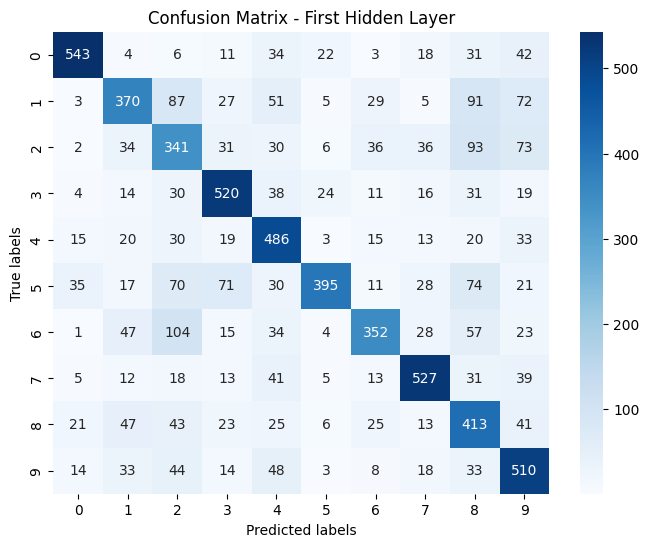

In [ ]:
plot_confusion_matrix(predictions_first_hidden_noisy, test_targets, "Confusion Matrix - First Hidden Layer")

The confusion matrix for predictions made by the first layer of the DBN highlights significant errors in some classes. Although the diagonal values are dominant, suggesting that the layer captures some useful features, but is not yet optimal at correctly distinguishing all classes.

For example, ま/ma (Class 6) is often misclassified as す/su (Class 2) and き/ki (Class 1).

は/ha (Class 5) is confused with つ/tsu (Class 3) and す/su (Class 2).

れ/re (Class 8) shows a spread of misclassifications, particularly with す/su (Class 2).

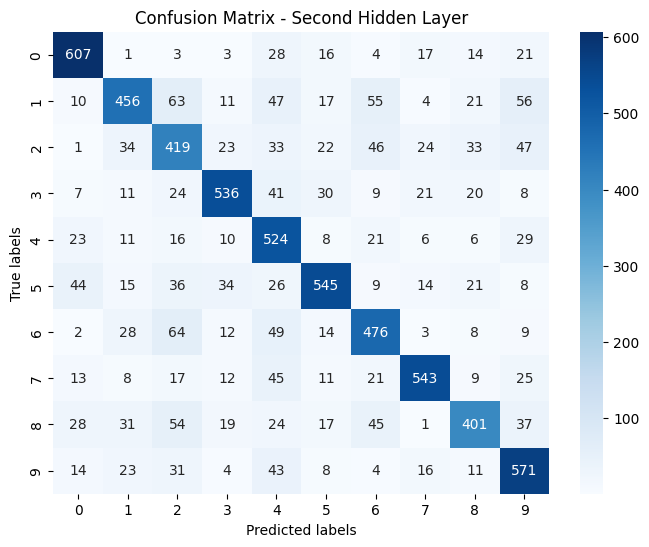

In [ ]:
plot_confusion_matrix(predictions_second_hidden_noisy, test_targets, "Confusion Matrix - Second Hidden Layer")

The confusion matrix for predictions made by the second layer of the DBN: お/o

*   つ/tsu (Class 3) continues to exhibit some overlap with は/ha (Class 5), but the separation has improved compared to the first hidden layer.
*   や/ya (Class 7) is better distinguished, with most predictions falling correctly, though れ/re (Class 8) still causes minor confusion, which makes sense given their somewhat similar structures.
*  れ/re (Class 8) and を/wo (Class 9) show improved classification but still share occasional confusion.


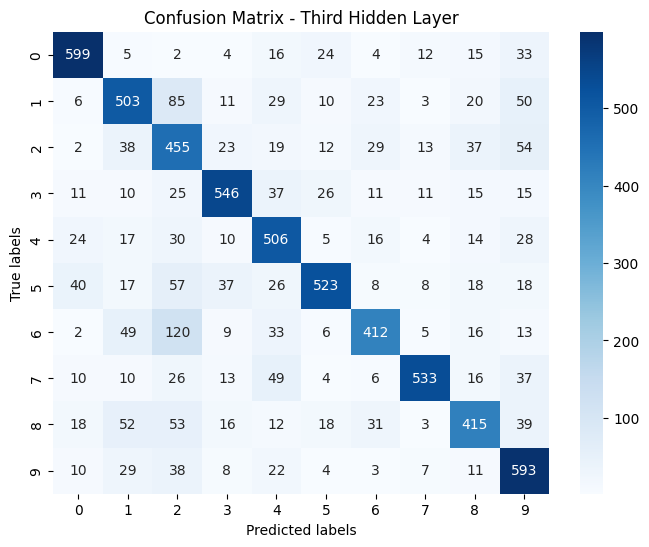

In [ ]:
plot_confusion_matrix(predictions_third_hidden_noisy, test_targets, "Confusion Matrix - Third Hidden Layer")

The confusion matrix for predictions made by the third layer of the DBN shows a slight improvement, misclassification errors , however, remain similar

Let's no see what happens with our ffn model

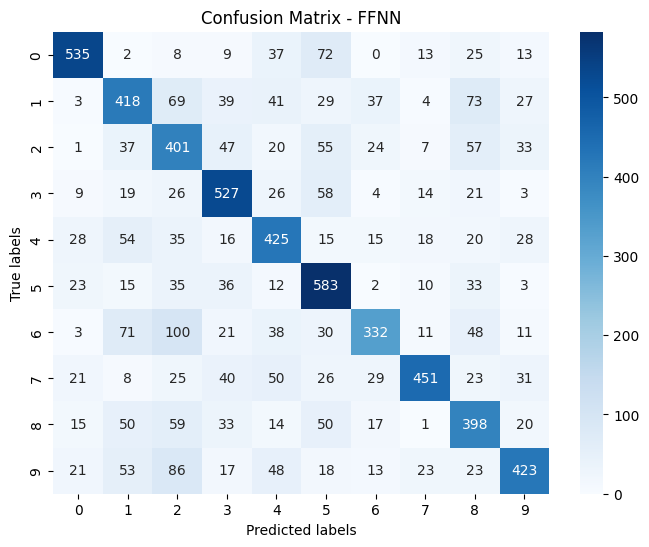

In [ ]:
plot_confusion_matrix(predictions_ffnn_noise, test_targets, "Confusion Matrix - FFNN")

Overall, we can clearly see that the ffn is making multiple classification mistakes amongst different classes, notably, some classification errors seem to be consistent with our dbn model, す/su (Class 2) and ま/ma (Class 6)

## Psychometric curves

in this part of the notebook we plot **psychometric curves** which describe the decrease in classification accuracy as a function of noise level, providing a more comprehensive understanding of the models' behavior in the presence of noisy data.

In [ ]:
def plot_noise_robustness_curves(noise_levels):
  accuracy_values_first_hidden = []
  accuracy_values_second_hidden = []
  accuracy_values_third_hidden = []
  accuracy_values_ffnn = []

  for noise_level in noise_levels:
    acc = get_accuracy_values_at_noise_level(noise_level)
    accuracy_values_first_hidden.append(acc[0])
    accuracy_values_second_hidden.append(acc[1])
    accuracy_values_third_hidden.append(acc[2])
    accuracy_values_ffnn.append(acc[3])

  fig, ax = plt.subplots()
  ax.plot(range(len(noise_levels)), accuracy_values_first_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_second_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_third_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_ffnn)

  ax.set_title("Robustness to noise")
  ax.set_xlabel("Noise level (%)")
  ax.set_ylabel("Accuracy")
  plt.xticks(range(len(noise_levels)), [int(l*100) for l in noise_levels])
  plt.legend(["First hidden", "Second hidden", "Third hidden", "FFNN"])

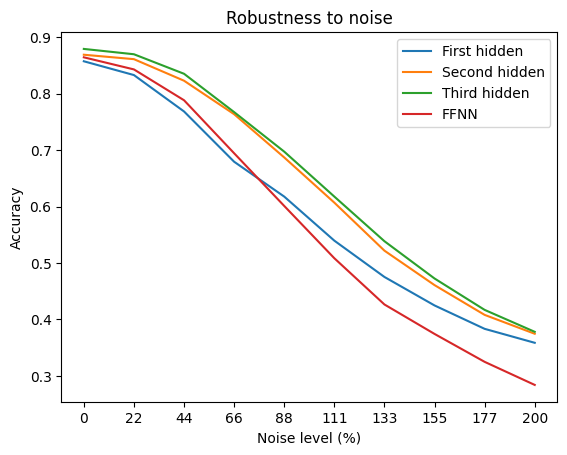

In [ ]:
noise_levels = np.linspace(0,2,10)
plot_noise_robustness_curves(noise_levels)

Like we saw during the labs, DBNs are better at dealing with noisy images regardless of noise level

# Perturbing the models with adversarial attacks

## Adversarial Attacks and the Fast Gradient Sign Method (FGSM)

In adversarial attacks, the objective is to alter the input in a way that causes the model to misclassify it. One common technique to generate such adversarial samples is the **Fast Gradient Sign Method (FGSM)**, which directly adjusts the input, not the model's parameters. The goal is to create an input that leads the model to make an incorrect prediction.

In **FGSM**, the input is adjusted in the direction of the gradient, which increases the loss function, as opposed to the decrease seen during gradient descent in model training.

The parameter `epsilon` governs the magnitude of the attack, and `data_grad` represents the gradient of the loss with respect to the input image. By adding the perturbation derived from the gradient, we generate an image that exploits the model's weaknesses, making it more likely to be misclassified.

<div>
<img src="https://miro.medium.com/v2/resize:fit:1400/1*PmCgcjO3sr3CPPaCpy5Fgw.png" width="700"/>
</div>


In [ ]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()

    ### TASK: Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*(sign_data_grad)

    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    # Return the perturbed image
    return perturbed_image

We need to define a unified architecture incorporating the DBN + readout layers, which allows to compute the gradient of the loss (classification task) with respect to the input data that is being processed.

In [ ]:
class DBNWithReadOut(torch.nn.Module):
    def __init__(self, dbn_mnist, readout):
        super().__init__()
        self.readout = readout
        self.readout_level = 2 #using top read out layer (not other layers)
        self.dbn_mnist = dbn_mnist
        self._require_grad()

    def _require_grad(self):
      for rbm in self.dbn_mnist.rbm_layers:
        rbm.W.requires_grad_()
        rbm.h_bias.requires_grad_()

    def forward(self, image):
      """This forward pass uses probabilities instead of samples as RBM activations
       to backpropagate the gradient"""
      p_v = image
      hidden_states = [] #compute hidden unit activation for each layer of the dbm and when you get to the last one pass it in the read out classifier
      for rbm in self.dbn_mnist.rbm_layers:
        p_v = p_v.view((p_v.shape[0], -1))  # flatten
        p_v, v = rbm(p_v)
        hidden_states.append(p_v)
      return self.readout.forward(hidden_states[self.readout_level]) #pass final hidden state to the read out classifier

In [ ]:
dbn_with_readout = DBNWithReadOut(dbn_KMNIST, linear_classifiers[2]) #images and classifier as input

Let's see what an adversiarial sample looks like. Let't take one sample from the test set:

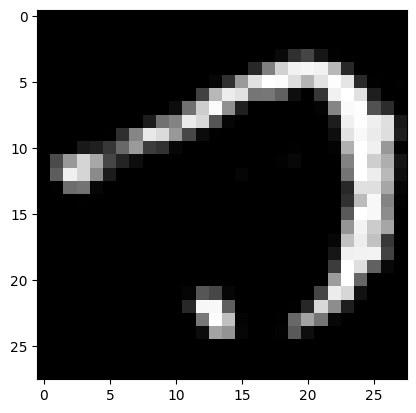

In [ ]:
#initial image with no attack
test_sample_idx = 1
test_image = test_data[test_sample_idx].reshape(1, 784)
__ = plt.imshow(test_image.reshape(28,28).to('cpu'), cmap = 'gray')

Let's classify this "clean" image using one of the models we previously trained and then modify the image to attack the network.

To change the model we attack, you can modify the value of the model variable in the cell below (choosing between ffnn and dbn_with_readout).

In [ ]:
attacked_model = dbn_with_readout
#attacked_model = ffnn

In [ ]:
test_image.requires_grad_() #compute grad of each pixel to use it for the attack
model_outputs = attacked_model(test_image)
prediction = torch.argmax(model_outputs)
print(f"The prediction of the model for this clean sample is {prediction}.") #correct

The prediction of the model for this clean sample is 3.


Let's create and visualize the corresponding adversarial sample. The function loss.backward() computes the gradient for every parameter that was activated using the call requires_grad=True.

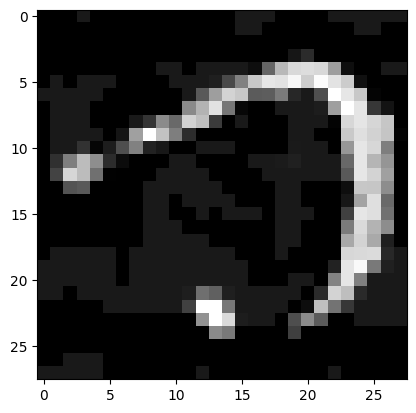

In [ ]:
epsilon = 0.1  # define strenght of the attack (hyperparameter)
test_image_label = test_targets[test_sample_idx].unsqueeze(0)  # get ground truth label for that image
loss_value = torch.nn.functional.cross_entropy(model_outputs, test_image_label)  # get loss value (checking model output)
attacked_model.zero_grad() #propagate the loss backward until we get the pixel level
loss_value.backward(retain_graph=True)
image_grad = test_image.grad.data  # get the gradient of each pixel in the image w.r.t. the loss


perturbed_image = fgsm_attack(test_image, epsilon, image_grad)
perturbed_image_np = perturbed_image.detach().to('cpu').numpy()
__ = plt.imshow(perturbed_image_np.reshape(28,28), cmap = 'gray')

In [ ]:
model_outputs = attacked_model(perturbed_image.view((perturbed_image.shape[0], -1)))
print(f"The prediction of the model for the perturbed sample is {torch.argmax(model_outputs)}.")

The prediction of the model for the perturbed sample is 3.


##Resisting to adversarial attacks



The goal is to create a new class that integrates a pre-trained **Deep Belief Network (DBN)** with a **linear readout layer** to form a complete classification model. This approach merges the unsupervised learning capabilities of the DBN with the supervised classification power of the linear layer.

The combined DBN with the readout layer will serve as the target for adversarial attacks.


In [ ]:
def test_robustness_to_attack(model, device, test_loader, epsilon, num_steps=0, verbose=True): # measure resilience across different values of epsilon
    correct = 0  # count number of correct classifications
    print_reconstruction = num_steps > 0  # if we request for top-down reconstruction, show the resulting image

    for data, target in tqdm(test_loader): #data feed as data loader to create handy way to provide data to the function
        data, target = data.to(device), target.to(device)
        data = data.reshape(-1, 784) # reshape every couple of data and target
        data.requires_grad = True  # we need to get the gradient to perform the attack (need to memorize all of them)

        output = model.forward(data)  # forward pass through the model

        init_pred = torch.argmax(output)  # prediction before the attack (just get the max)

        if (print_reconstruction and verbose):  # (just to visualization)
          print("\nHere's the original sample:\n")
          plt.imshow(data[0].detach().to('cpu').numpy().reshape(28,28))
          plt.show()

        loss_value = torch.nn.functional.cross_entropy(output, target) # get loss value
        model.zero_grad() # we do it the same way we did before
        loss_value.backward()
        data_grad = data.grad.data  # collect the gradient with respect to the input data
        perturbed_data = fgsm_attack(data, epsilon, data_grad)  # call the attack function previously defined

        if (print_reconstruction and verbose):
            print("\nHere's a perturbed sample:\n")
            plt.imshow(perturbed_data[0].detach().to('cpu').numpy().reshape(28,28))
            plt.show()

        # If requested, reconstruct the input iterating bottom-up and top-down sampling
        if num_steps > 0:
            for __ in range(0, num_steps):
                perturbed_data, __ = model.dbn_mnist.reconstruct(perturbed_data)
            if (print_reconstruction and verbose):
                print(f"\nHere's what a {num_steps}-steps reconstructed sample looks like:\n")
                plt.imshow(perturbed_data[0].detach().to('cpu').numpy().reshape(28,28))
                plt.show()
                print_reconstruction = False

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        # get the index of the max element in the output
        final_pred = output.max(1, keepdim=True)[1]
        final_pred = output.argmax(-1)
        correct += (final_pred == target).sum()

    # Calculate final accuracy for this epsilon (test accuracy with respect to adversarial attack)
    final_acc = correct/float(len(test_loader.sampler))
    print("\nEpsilon: {}\nTest Accuracy: {:.2f}%\n".format(epsilon, final_acc*100))

    return final_acc.item()

In [ ]:
test_loader1 = torch.utils.data.DataLoader(
    tv.datasets.KMNIST('data/', train=False, download=True, transform=tv.transforms.Compose([tv.transforms.ToTensor()])),
    batch_size=100, shuffle=True)

Let's see how good the FFNN does:

In [ ]:
final_acc = test_robustness_to_attack(ffnn, device,
                                      test_loader1, epsilon=0.05, # this epsilon is impacting a lot, the accuracy is really small
                                      num_steps=0)

  0%|          | 0/100 [00:00<?, ?it/s]


Epsilon: 0.05
Test Accuracy: 45.64%



Let's now compare compare with the read-out trained on the hidden representations of the DBN:

  0%|          | 0/100 [00:00<?, ?it/s]


Here's the original sample:



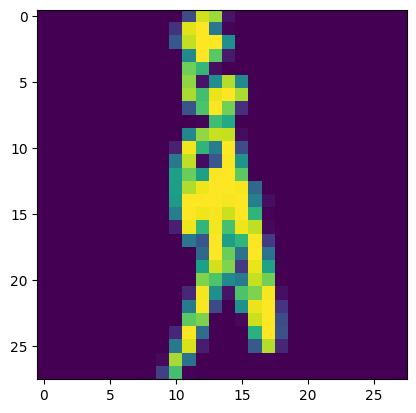


Here's a perturbed sample:



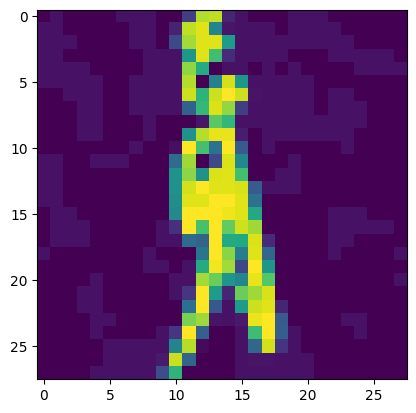


Here's what a 2-steps reconstructed sample looks like:



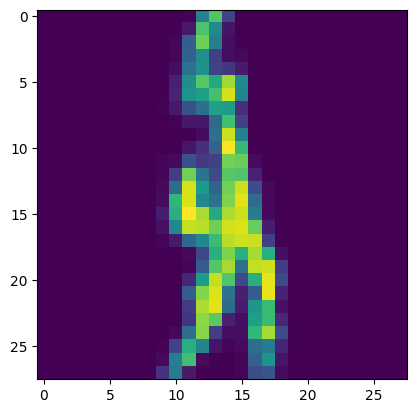


Epsilon: 0.05
Test Accuracy: 69.50%



In [ ]:
final_acc = test_robustness_to_attack(dbn_with_readout, device,
                                      test_loader1, epsilon=0.05,
                                      num_steps=2)

## Effect of the noise parameter $\epsilon$

Let's compare the robustness of each model to adversarial attacks of different "strengths":

In [ ]:
epsilon_values = [0, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30]

def test_epsilon_values_effect(model, n_steps):
  accuracies = list()

  for eps in epsilon_values:
      acc = test_robustness_to_attack(model, device, test_loader1, eps, num_steps=n_steps, verbose=False)  # set verbose to False to avoid displaying too many images
      accuracies.append(acc)

  return accuracies

In [ ]:
%%capture
accuracies_ffnn = test_epsilon_values_effect(ffnn, n_steps=0)
accuracies_dbn_0 = test_epsilon_values_effect(dbn_with_readout, n_steps=0)
accuracies_dbn_1 = test_epsilon_values_effect(dbn_with_readout, n_steps=2)

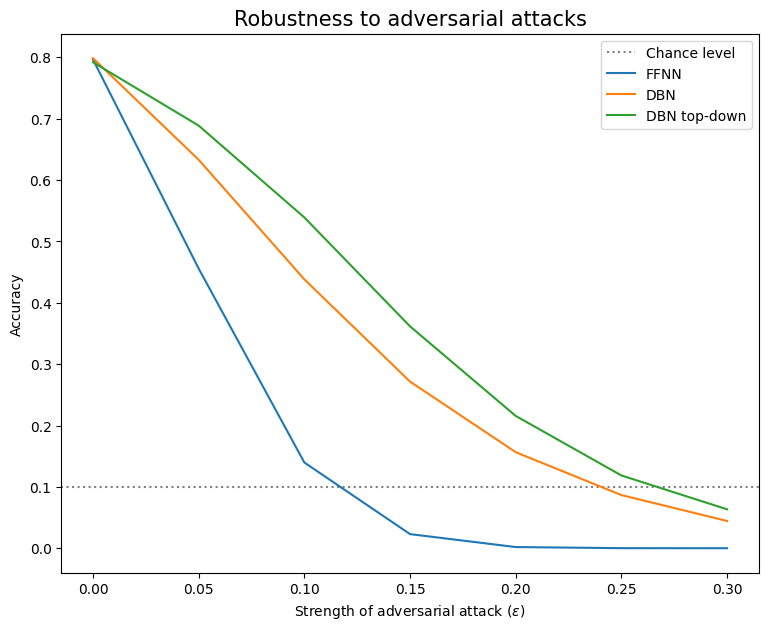

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(9, 7), sharey=True)

__ = ax.axhline(0.1, color='gray', linestyle=':')
__ = ax.plot(epsilon_values, accuracies_ffnn)
__ = ax.plot(epsilon_values, accuracies_dbn_0)
__ = ax.plot(epsilon_values, accuracies_dbn_1)
__ = ax.set_xlabel("Strength of adversarial attack ($\epsilon$)")
__ = ax.set_ylabel("Accuracy")
__ = ax.set_title("Robustness to adversarial attacks", {'fontsize': 15})
__ = ax.legend(["Chance level", "FFNN", "DBN", "DBN top-down"])

The graph demonstrates that the DBN exhibits better robustness against adversarial attacks compared to the FFNN. The accuracy curve for the FFNN drops sharply as the intensity of the attack increases, indicating that this model is highly susceptible to adversarial perturbations. On the other hand, the DBN curves (both the standard version and the top-down reconstruction variant) show a more gradual decline in accuracy, suggesting that these networks are more resilient, maintaining higher accuracy even under stronger attacks.

DBNs are more resistant to adversarial attacks because they learn more robust hierarchical representations during unsupervised pretraining. This allows them to capture abstract and general patterns that are less sensitive to small perturbations.